In [1]:
!pip install -q transformers datasets torch py_vncorenlp accelerate scikit-learn underthesea protobuf==3.20.3

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.5 MB/

In [2]:
import pandas as pd
import torch
import re
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import Dataset
import shutil

In [3]:
from datasets import load_dataset

df = load_dataset("anotherpolarbear/vietnamese-sentiment-analysis")


README.md:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/7786 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2224 [00:00<?, ? examples/s]

In [4]:
print(df)

DatasetDict({
    train: Dataset({
        features: ['comment', 'label'],
        num_rows: 7786
    })
    test: Dataset({
        features: ['comment', 'label'],
        num_rows: 2224
    })
})


In [5]:
# 1. ĐỌC FILE TRAIN VÀ TEST
try:
    df_train = df["train"]
    df_test = df["test"]
    print(f"-> Train: {len(df_train)} dòng, Test: {len(df_test)} dòng")
except:
    raise

-> Train: 7786 dòng, Test: 2224 dòng


**XỬ LÝ DỮ LIỆU (GOM NHÓM & OVERSAMPLING)**

Tiền xử lý dữ liệu

In [6]:
teencode_dict = {
    "k": "không", "ko": "không", "kh": "không", "hok": "không",
    "dc": "được", "đc": "được",
    "sp": "sản phẩm",
    "dt": "điện thoại", "đt": "điện thoại",
    "ok": "tốt", "oke": "tốt", "good": "tốt",
    "nv": "nhân viên",
    "wiffi": "wifi", "wf": "wifi",
    "mik": "mình", "mjk": "mình",
    "e" : "em" , "dthoai" : "điện thoại"
}

def preprocess_text(text):
    if not isinstance(text, str):
        return str(text)
    
    # 1. CHUẨN HÓA KÝ TỰ (LOWERCASE)
    text = text.lower()
    
    # 2. XỬ LÝ NHIỄU
    # Loại bỏ HTML tags (nếu có)
    text = re.sub(r'<.*?>', '', text)
    # Loại bỏ URL bắt đầu bằng http/https
    text = re.sub(r'http\S+', '', text)
    # Loại bỏ email
    text = re.sub(r'\S+@\S+', '', text)
    
    # Loại bỏ các ký tự đặc biệt, NHƯNG GIỮ LẠI:
    # - Các ký tự chữ cái và số (\w bao gồm cả tiếng Việt có dấu)
    # - Khoảng trắng (\s)
    # - Dấu chấm than (!) và Dấu hỏi (?) vì mang sắc thái cảm xúc
    text = re.sub(r'[^\w\s!?]', ' ', text)
    
    # Loại bỏ dấu gạch dưới _ (do \w giữ lại _ mà ta muốn loại bỏ)
    text = text.replace('_', ' ')
    
    # Loại bỏ khoảng trắng thừa (ví dụ: "  " -> " ")
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. CHUẨN HÓA TEENCODE
    # Tách từ để xử lý chính xác từ đơn (tránh thay thế nhầm chữ cái trong từ khác)
    words = text.split()
    words = [teencode_dict.get(word, word) for word in words]
    text = ' '.join(words)
    
    return text



In [7]:
# 1. Hàm wrapper để xử lý từng dòng dữ liệu (example)
def map_preprocess(example):
    # Thay 'text' bằng 'comment' nếu dataset của bạn dùng tên đó
    column_name = 'comment' 
    
    if example[column_name] is not None:
        example[column_name] = preprocess_text(example[column_name])
    return example

# 2. Áp dụng lên dataset
df_train = df_train.map(map_preprocess)

# 3. Xem thử kết quả
print(df_train[0])

Map:   0%|          | 0/7786 [00:00<?, ? examples/s]

{'comment': 'mới mua máy này tại thegioididong thốt nốt cảm thấy tốt bin trâu chụp ảnh đẹp loa nghe to bắt wifi khỏe sóng ổn định giá thành vừa với túi tiền nhân viên tư vấn nhiệt tình', 'label': 5}


In [8]:
# 1. Hàm wrapper để làm việc với Dataset.map
def convert_stars_to_classes(example):
    # Giả sử tên cột chứa số sao là 'label' hoặc 'rating'
    # Bạn hãy kiểm tra tên cột của mình bằng df_train.column_names
    column_name = 'label' 
    
    star = int(example[column_name])
    
    if star <= 2:
        example[column_name] = 0  # Tiêu cực
    elif star == 3:
        example[column_name] = 1  # Trung tính
    else: # 4, 5
        example[column_name] = 2  # Tích cực
        
    return example

# 2. Áp dụng lên dataset
df_train = df_train.map(convert_stars_to_classes)

# 3. Kiểm tra phân bổ các lớp sau khi gom nhóm
from collections import Counter
labels = df_train['label']
print("Phân bổ các lớp (0: Neg, 1: Neu, 2: Pos):", Counter(labels))

Map:   0%|          | 0/7786 [00:00<?, ? examples/s]

Phân bổ các lớp (0: Neg, 1: Neu, 2: Pos): Counter({2: 4936, 0: 1838, 1: 1012})


In [9]:
from datasets import concatenate_datasets
from collections import Counter

# 1. Chia dataset gốc (chưa cân bằng) thành Train và Valid (8:2)
split_data = df_train.train_test_split(test_size=0.2, seed=42)
train_raw = split_data['train']
valid_dataset = split_data['test'] # Tập này giữ nguyên, không Oversampling

print(f"Phân bổ tập Valid (Gốc): {Counter(valid_dataset['label'])}")

# 2. Thực hiện Oversampling CHỈ trên tập Train
# Tách các lớp trong tập Train
train_pos = train_raw.filter(lambda x: x['label'] == 2)
train_neg = train_raw.filter(lambda x: x['label'] == 0)
train_neu = train_raw.filter(lambda x: x['label'] == 1)

# Lấy số lượng của lớp lớn nhất làm mục tiêu
target_size = len(train_pos)

def oversample_dataset(dataset, target_size):
    current_size = len(dataset)
    if current_size == 0: return dataset
    indices = [i % current_size for i in range(target_size)]
    return dataset.select(indices)

# Nhân bản lớp 0 và 1 trong tập Train
train_neg_over = oversample_dataset(train_neg, target_size)
train_neu_over = oversample_dataset(train_neu, target_size)

# 3. Gộp lại thành tập Train đã cân bằng
train_dataset = concatenate_datasets([train_pos, train_neg_over, train_neu_over])
train_dataset = train_dataset.shuffle(seed=42)

print(f"Phân bổ tập Train sau Oversampling: {Counter(train_dataset['label'])}")
print(f"Tổng số mẫu tập Train mới: {len(train_dataset)}")

Phân bổ tập Valid (Gốc): Counter({2: 1009, 0: 365, 1: 184})


Filter:   0%|          | 0/6228 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6228 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6228 [00:00<?, ? examples/s]

Phân bổ tập Train sau Oversampling: Counter({1: 3927, 2: 3927, 0: 3927})
Tổng số mẫu tập Train mới: 11781


In [10]:
from transformers import AutoTokenizer
from underthesea import word_tokenize

# 1. Tải bộ Tokenizer của PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# 2. Hàm xử lý: Tách từ trên cột 'comment' + Tokenize
def preprocess_and_tokenize(examples):
    # Lấy dữ liệu từ cột 'comment', đảm bảo chuyển về string để tránh lỗi None
    texts = [str(t) for t in examples["comment"]]
    
    # Bước A: Tách từ tiếng Việt (format 'từ_ghép')
    segmented_texts = [word_tokenize(t, format="text") for t in texts]
    
    # Bước B: Tokenize (chuyển sang ID số)
    return tokenizer(
        segmented_texts,
        padding="max_length",
        truncation=True,
        max_length=128
    )

# 3. Áp dụng cho tập Train và Valid
print(">>> Đang Tokenize tập Train (cột 'comment')...")
train_tokenized = train_dataset.map(preprocess_and_tokenize, batched=True)

print(">>> Đang Tokenize tập Valid (cột 'comment')...")
valid_tokenized = valid_dataset.map(preprocess_and_tokenize, batched=True)

# 4. Dọn dẹp dataset: Chỉ giữ lại các cột mà Model cần
# Các cột cần giữ: 'input_ids', 'token_type_ids', 'attention_mask', 'label'
all_cols = train_tokenized.column_names
cols_to_remove = [c for c in all_cols if c not in ['input_ids', 'token_type_ids', 'attention_mask', 'label']]

train_tokenized = train_tokenized.remove_columns(cols_to_remove)
valid_tokenized = valid_tokenized.remove_columns(cols_to_remove)

# 5. Chuyển sang định dạng Tensor của PyTorch
train_tokenized.set_format("torch")
valid_tokenized.set_format("torch")

print(">>> Hoàn tất! Cấu trúc dữ liệu hiện tại:", train_tokenized[0].keys())

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

>>> Đang Tokenize tập Train (cột 'comment')...


Map:   0%|          | 0/11781 [00:00<?, ? examples/s]

>>> Đang Tokenize tập Valid (cột 'comment')...


Map:   0%|          | 0/1558 [00:00<?, ? examples/s]

>>> Hoàn tất! Cấu trúc dữ liệu hiện tại: dict_keys(['label', 'input_ids', 'token_type_ids', 'attention_mask'])


In [11]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import os
import warnings

# Tắt các log cảnh báo từ hệ thống và TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")

# 1. Tải mô hình PhoBERT cho bài toán phân loại (3 nhãn)
# Nếu bạn dùng GPU, mô hình sẽ tự động được đưa vào CUDA
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base", 
    num_labels=3
)

# 2. Hàm tính toán chỉ số đánh giá (Metrics)
# Vì tập Valid không cân bằng, chúng ta tập trung vào Macro F1-Score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Tính Accuracy và Macro F1
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    
    return {
        'accuracy': acc,
        'f1_macro': f1
    }

# 3. Thiết lập các tham số huấn luyện (Hyperparameters)
training_args = TrainingArguments(
    output_dir="./phobert-sentiment-results", # Thư mục lưu kết quả
    num_train_epochs=6,                       # Số vòng huấn luyện
    per_device_train_batch_size=16,           # Batch size cho training
    per_device_eval_batch_size=16,            # Batch size cho evaluation
    learning_rate=2e-5,                       # Tốc độ học (thường là 2e-5 cho BERT)
    warmup_steps=500,                         # Tăng dần LR để tránh sốc ban đầu
    weight_decay=0.01,                        # Tránh Overfitting
    
    # Chiến lược đánh giá và lưu trữ
    eval_strategy="epoch",              # Đánh giá sau mỗi epoch
    save_strategy="epoch",                    # Lưu checkpoint sau mỗi epoch
    logging_steps=100,                        # Ghi log sau mỗi 100 bước
    
    # Lưu mô hình tốt nhất dựa trên F1
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    
    report_to="none"                          # Có thể đổi thành 'tensorboard' để vẽ đồ thị
)

# 4. Khởi tạo Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    compute_metrics=compute_metrics,
)

# 5. Bắt đầu huấn luyện
print(">>> Bắt đầu huấn luyện mô hình...")
trainer.train()

2026-01-06 16:35:14.882952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767717315.110624      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767717315.178266      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

>>> Bắt đầu huấn luyện mô hình...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.737900,0.536307,0.774711,0.650957
2,0.513000,0.553320,0.778562,0.647332
3,0.291500,0.684188,0.778562,0.660516
4,0.201100,0.812493,0.788832,0.635703
5,0.138700,0.895490,0.791399,0.660203
6,0.100000,0.955403,0.787548,0.654175


TrainOutput(global_step=2214, training_loss=0.3684771745024012, metrics={'train_runtime': 1115.0796, 'train_samples_per_second': 63.391, 'train_steps_per_second': 1.986, 'total_flos': 4649608761380352.0, 'train_loss': 0.3684771745024012, 'epoch': 6.0})

In [12]:
import os

# 1. Định nghĩa tên thư mục lưu trữ
model_path = "./my_phobert_sentiment_model"

# 2. Lưu mô hình và tokenizer (quan trọng để dùng cho inference sau này)
print(f">>> Đang lưu mô hình vào: {model_path}")
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

# 3. Nén thư mục lại thành file .zip để dễ dàng tải xuống từ Kaggle
import shutil
shutil.make_archive("sentiment_model_v1", 'zip', model_path)

print(">>> Hoàn tất! Bạn có thể tìm thấy file 'sentiment_model_v1.zip' ở cột bên phải (Output) của Kaggle.")

>>> Đang lưu mô hình vào: ./my_phobert_sentiment_model
>>> Hoàn tất! Bạn có thể tìm thấy file 'sentiment_model_v1.zip' ở cột bên phải (Output) của Kaggle.


=== BẢNG THỐNG KÊ CHI TIẾT ===


,Epoch,Train Loss,Valid Loss,Accuracy,F1 Macro
0,1,1.0952,0.536307,0.774711,0.650957
1,2,0.9228,0.553320,0.778562,0.647332
2,3,0.7379,0.684188,0.778562,0.660516
3,4,0.6812,0.812493,0.788832,0.635703
4,5,0.5995,0.895490,0.791399,0.660203
5,6,0.5528,0.955403,0.787548,0.654175


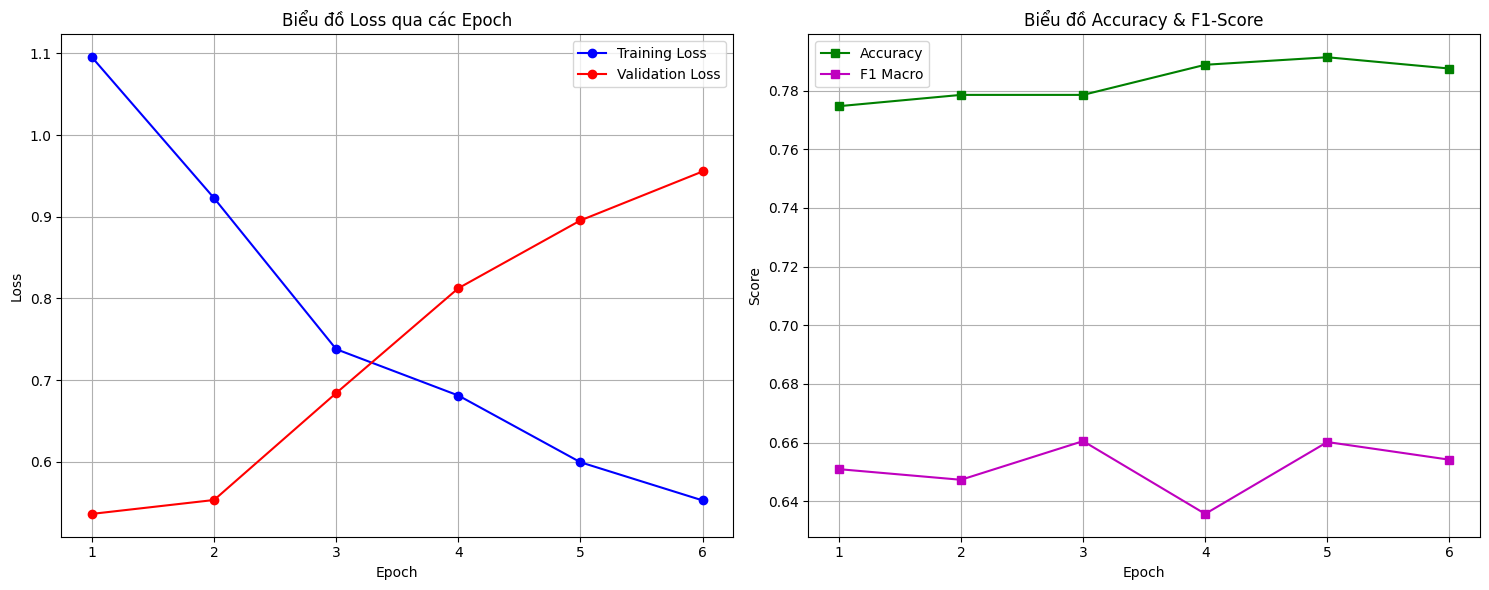


>>> KẾT QUẢ TỐT NHẤT TẠI EPOCH 3:
- Accuracy: 0.7786
- F1 Macro: 0.6605


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Trích xuất dữ liệu từ lịch sử huấn luyện của trainer
history = trainer.state.log_history

# Tách dữ liệu training và evaluation
train_loss = [log['loss'] for log in history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
eval_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
eval_f1 = [log['eval_f1_macro'] for log in history if 'eval_f1_macro' in log]
epochs = range(1, len(eval_loss) + 1)

# 2. Tạo bảng thống kê số liệu
df_metrics = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss[:len(epochs)], # Đảm bảo cùng độ dài
    'Valid Loss': eval_loss,
    'Accuracy': eval_acc,
    'F1 Macro': eval_f1
})

print("=== BẢNG THỐNG KÊ CHI TIẾT ===")
display(df_metrics)

# 3. Vẽ đồ thị
plt.figure(figsize=(15, 6))

# Đồ thị Loss (Train vs Valid)
plt.subplot(1, 2, 1)
plt.plot(epochs, df_metrics['Train Loss'], 'b-o', label='Training Loss')
plt.plot(epochs, df_metrics['Valid Loss'], 'r-o', label='Validation Loss')
plt.title('Biểu đồ Loss qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Đồ thị Accuracy & F1
plt.subplot(1, 2, 2)
plt.plot(epochs, df_metrics['Accuracy'], 'g-s', label='Accuracy')
plt.plot(epochs, df_metrics['F1 Macro'], 'm-s', label='F1 Macro')
plt.title('Biểu đồ Accuracy & F1-Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Tìm và in ra kết quả tốt nhất
best_epoch = df_metrics.loc[df_metrics['F1 Macro'].idxmax()]
print(f"\n>>> KẾT QUẢ TỐT NHẤT TẠI EPOCH {int(best_epoch['Epoch'])}:")
print(f"- Accuracy: {best_epoch['Accuracy']:.4f}")
print(f"- F1 Macro: {best_epoch['F1 Macro']:.4f}")

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from underthesea import word_tokenize

# 1. Cấu hình đường dẫn và thiết bị
model_path = "./my_phobert_sentiment_model" # Đường dẫn thư mục bạn đã lưu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f">>> Đang tải mô hình từ: {model_path}...")

# 2. Tải Tokenizer và Model từ thư mục đã lưu
# AutoModelForSequenceClassification sẽ tự động nhận diện cấu hình 3 nhãn bạn đã train
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Đưa mô hình vào GPU (nếu có) và chuyển sang chế độ eval
model.to(device)
model.eval()

# 3. Hàm dự đoán
def predict(text):
    # Tách từ tiếng Việt chuẩn PhoBERT
    text_segmented = word_tokenize(text, format="text")
    
    # Tokenize
    inputs = tokenizer(
        text_segmented, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=128
    ).to(device)
    
    # Dự đoán
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Lấy xác suất và nhãn
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_label = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_label].item()
    
    # Map nhãn số sang chữ
    label_map = {0: "TIÊU CỰC 😡", 1: "TRUNG TÍNH 😐", 2: "TÍCH CỰC 😍"}
    
    return label_map[pred_label], confidence



>>> Đang tải mô hình từ: ./my_phobert_sentiment_model...


In [15]:
# 4. Chạy thử nghiệm
print("-" * 30)
test_input = input("Nhập câu bình luận của bạn: ") if 'input' in globals() else "sản phẩm thật sự đáng kinh ngạc"
result, conf = predict(test_input)

print(f"\nKết quả dự đoán:")
print(f">> Câu: '{test_input}'")
print(f">> Nhãn: {result} (Độ tin cậy: {conf:.2%})")

------------------------------

Kết quả dự đoán:
>> Câu: 'sản phẩm thật sự đáng kinh ngạc'
>> Nhãn: TÍCH CỰC 😍 (Độ tin cậy: 92.43%)


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

In [17]:
# 5. BIỂU DIỄN VĂN BẢN BẰNG TF-IDF N-GRAM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Chuyển đổi dữ liệu từ Dataset sang List văn bản (chọn đúng cột 'comment')
# Chúng ta sử dụng dữ liệu đã tách từ (segmented) nếu có, hoặc dùng cột gốc
train_texts = [str(t) for t in train_dataset['comment']]
val_texts   = [str(t) for t in valid_dataset['comment']]

# 2. Khởi tạo và khớp TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),   # Dùng unigram + bigram
    min_df=5,             # Bỏ từ xuất hiện ít hơn 5 lần
    max_df=0.9,           # Bỏ từ xuất hiện quá 90%
    max_features=50000,   # Giới hạn số đặc trưng
    sublinear_tf=True     # Dùng log(tf) cho ổn định
)

X_train = tfidf_vectorizer.fit_transform(train_texts)
X_val   = tfidf_vectorizer.transform(val_texts)

# Lấy nhãn tương ứng
y_train = train_dataset['label']
y_val   = valid_dataset['label']

print(f"Kích thước ma trận TF-IDF train: {X_train.shape}")
print(f"Kích thước ma trận TF-IDF val  : {X_val.shape}")

# 3. Huấn luyện Logistic Regression (Đã loại bỏ multi_class)
print("\n>>> Đang huấn luyện mô hình Logistic Regression...")
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
clf.fit(X_train, y_train)

# 4. Dự đoán và báo cáo kết quả
y_pred = clf.predict(X_val)
print("\n" + "="*40)
print("KẾT QUẢ MÔ HÌNH TF-IDF + LOGISTIC REGRESSION")
print("="*40)
print(classification_report(y_val, y_pred, target_names=["Tiêu cực", "Trung tính", "Tích cực"]))

Kích thước ma trận TF-IDF train: (11781, 22026)
Kích thước ma trận TF-IDF val  : (1558, 22026)

>>> Đang huấn luyện mô hình Logistic Regression...

KẾT QUẢ MÔ HÌNH TF-IDF + LOGISTIC REGRESSION
              precision    recall  f1-score   support

    Tiêu cực       0.66      0.76      0.71       365
  Trung tính       0.31      0.30      0.31       184
    Tích cực       0.92      0.88      0.90      1009

    accuracy                           0.78      1558
   macro avg       0.63      0.65      0.64      1558
weighted avg       0.79      0.78      0.78      1558



In [18]:
# 6. MÔ HÌNH 1: TF-IDF + LINEAR SVM
# ---------------------------------------------------------
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# 1. Lấy nhãn từ dataset (Đảm bảo tên biến chính xác)
# Trong các bước trước, nhãn của bạn nằm ở cột 'label'
y_train = train_dataset['label']
y_val   = valid_dataset['label']

# 2. Khởi tạo SVM tuyến tính
# C=1.0 là tham số mặc định, class_weight='balanced' giúp xử lý nếu tập Valid bị lệch
svm_clf = LinearSVC(
    C=1.0,
    class_weight='balanced',
    random_state=42,
    max_iter=2000 # Tăng số lần lặp để đảm bảo hội tụ
)

# 3. Huấn luyện (Sử dụng X_train đã tạo từ TF-IDF)
print(">>> Đang huấn luyện mô hình Linear SVM...")
svm_clf.fit(X_train, y_train)

# 4. Dự đoán trên tập val
val_pred_svm = svm_clf.predict(X_val)

# 5. Đánh giá
svm_acc = accuracy_score(y_val, val_pred_svm)
print("\n" + "="*40)
print("== KẾT QUẢ MÔ HÌNH: TF-IDF + Linear SVM ==")
print("="*40)
print(f"Accuracy: {svm_acc:.4f}")
print("\nClassification report:")
# label_map của bạn là 0: Tiêu cực, 1: Trung tính, 2: Tích cực
print(classification_report(y_val, val_pred_svm, target_names=["Tiêu cực", "Trung tính", "Tích cực"]))

>>> Đang huấn luyện mô hình Linear SVM...

== KẾT QUẢ MÔ HÌNH: TF-IDF + Linear SVM ==
Accuracy: 0.7863

Classification report:
              precision    recall  f1-score   support

    Tiêu cực       0.67      0.73      0.70       365
  Trung tính       0.33      0.23      0.27       184
    Tích cực       0.89      0.91      0.90      1009

    accuracy                           0.79      1558
   macro avg       0.63      0.62      0.62      1558
weighted avg       0.77      0.79      0.78      1558



In [19]:
# 8. MÔ HÌNH 2: TF-IDF + LOGISTIC REGRESSION
# ---------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Gán đúng nhãn từ Dataset (Tránh lỗi NameError)
# y_train và y_val tương ứng với cột 'label' trong dataset của bạn
train_labels = train_dataset['label']
val_labels   = valid_dataset['label']

# 2. Khởi tạo mô hình Logistic Regression
# n_jobs=-1: Sử dụng tất cả nhân CPU để tính toán nhanh hơn
# class_weight='balanced': Tự động điều chỉnh trọng số cho các lớp ít dữ liệu
log_clf = LogisticRegression(
    max_iter=1000,       # Tăng số vòng lặp để đảm bảo hội tụ
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)

# 3. Huấn luyện mô hình
print(">>> Đang huấn luyện Logistic Regression...")
log_clf.fit(X_train, train_labels)

# 4. Dự đoán trên tập Validation
val_pred_log = log_clf.predict(X_val)

# 5. Đánh giá kết quả
log_acc = accuracy_score(val_labels, val_pred_log)
print("\n" + "="*45)
print("== KẾT QUẢ MÔ HÌNH: TF-IDF + Logistic Regression ==")
print("="*45)
print(f"Accuracy: {log_acc:.4f}")
print("\nClassification report:")
# Nhãn: 0 (Tiêu cực), 1 (Trung tính), 2 (Tích cực)
print(classification_report(val_labels, val_pred_log, target_names=["Tiêu cực", "Trung tính", "Tích cực"]))


>>> Đang huấn luyện Logistic Regression...

== KẾT QUẢ MÔ HÌNH: TF-IDF + Logistic Regression ==
Accuracy: 0.7818

Classification report:
              precision    recall  f1-score   support

    Tiêu cực       0.66      0.76      0.71       365
  Trung tính       0.31      0.30      0.31       184
    Tích cực       0.92      0.88      0.90      1009

    accuracy                           0.78      1558
   macro avg       0.63      0.65      0.64      1558
weighted avg       0.79      0.78      0.78      1558

